<a href="https://colab.research.google.com/github/kwinkunks/notebooks/blob/master/Pandas_with_NPD_data_Colab-edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

# NPD data

Start here >> https://portal.diskos.cgg.com/whereoil-data/

Bit confusing as there are a lot of places to get data.

I'll start with FactPages because I've heard of that...

## FactPages... Use pandas to read CSV directly

Right-click and copy URL for CSV from this link:

http://factpages.npd.no/factpages/Default.aspx?culture=nb-no&nav1=field&nav2=TableView|Production|Saleable|Monthly

In [0]:
csv = "http://factpages.npd.no/ReportServer?/FactPages/TableView/field_production_monthly&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=213.236.218.114&CultureCode=nb-no"

In [0]:
import pandas as pd

df = pd.read_csv(csv)

In [3]:
df.head()

,prfInformationCarrier,prfYear,prfMonth,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3,prfPrdNGLNetMillSm3,prfPrdCondensateNetMillSm3,prfPrdOeNetMillSm3,prfPrdProducedWaterInFieldMillSm3,prfNpdidInformationCarrier
0,33/9-6 DELTA,2009,7,0.00025,0.0,-0.00004,0.0,0.00021,0.00051,44576
1,33/9-6 DELTA,2009,8,0.00325,0.0,0.00014,0.0,0.00339,0.00063,44576
2,33/9-6 DELTA,2009,9,0.00317,0.0,0.00010,0.0,0.00327,0.00316,44576
3,33/9-6 DELTA,2009,10,0.00294,0.0,0.00012,0.0,0.00306,0.00535,44576
4,33/9-6 DELTA,2009,11,-0.00001,0.0,-0.00004,0.0,-0.00005,0.00000,44576


In [4]:
len(df)

20003

We could save this if we wanted to...

In [0]:
#df.to_csv('npd.csv', index=False)

## Add a datetime

Give this a 'DS' (datestamp) column with `pandas` datetimes. To do this easily, we need columns named like `'year'`, `'month'`, `'day'`.

In [0]:
#df = pd.read_csv('npd.csv')

In [0]:
columns = {'prfYear': 'year',
           'prfMonth': 'month',
           'prfInformationCarrier': 'field',
           'prfPrdOilNetMillSm3': 'oil',
           'prfPrdOeNetMillSm3': 'OE',
           'prfPrdProducedWaterInFieldMillSm3': 'water',
          }

df = df.rename(columns=columns)

In [0]:
df['day'] = 1

In [0]:
df['DS'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('DS')

In [10]:
df.head()

,field,year,month,oil,prfPrdGasNetBillSm3,prfPrdNGLNetMillSm3,prfPrdCondensateNetMillSm3,OE,water,prfNpdidInformationCarrier,day
DS,,,,,,,,,,,
2009-07-01,33/9-6 DELTA,2009,7,0.00025,0.0,-0.00004,0.0,0.00021,0.00051,44576,1
2009-08-01,33/9-6 DELTA,2009,8,0.00325,0.0,0.00014,0.0,0.00339,0.00063,44576,1
2009-09-01,33/9-6 DELTA,2009,9,0.00317,0.0,0.00010,0.0,0.00327,0.00316,44576,1
2009-10-01,33/9-6 DELTA,2009,10,0.00294,0.0,0.00012,0.0,0.00306,0.00535,44576,1
2009-11-01,33/9-6 DELTA,2009,11,-0.00001,0.0,-0.00004,0.0,-0.00005,0.00000,44576,1


In [0]:
df = df[['field', 'oil', 'OE', 'water']]
df.OE -= df.oil

In [12]:
df.head()

,field,oil,OE,water
DS,,,,
2009-07-01,33/9-6 DELTA,0.00025,-0.00004,0.00051
2009-08-01,33/9-6 DELTA,0.00325,0.00014,0.00063
2009-09-01,33/9-6 DELTA,0.00317,0.00010,0.00316
2009-10-01,33/9-6 DELTA,0.00294,0.00012,0.00535
2009-11-01,33/9-6 DELTA,-0.00001,-0.00004,0.00000


## Pandas is very useful for time series!

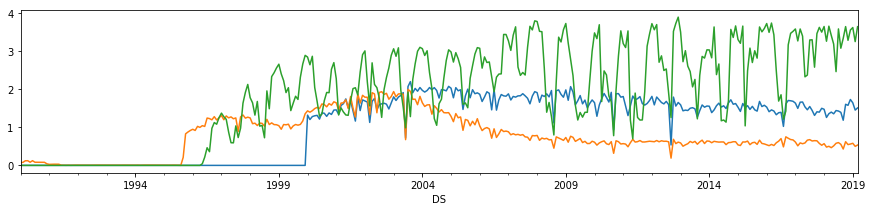

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))

df.water[df.field=='TROLL'].plot()
df.oil[df.field=='TROLL'].plot()
df.OE[df.field=='TROLL'].plot()

Once you're used to the `pandas` syntax, it's fairly easy to make the mean monthly production for a time range:

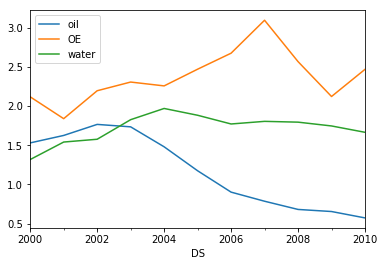

In [14]:
df.loc[df.field=='TROLL'].loc['2000':'2010'].resample('Y').mean().plot()

Or to get the summed annual production:

In [15]:
df.loc[df.field=='TROLL'].loc['2000':'2010'].resample('Y').sum()

,oil,OE,water
DS,,,
2000-12-31,18.36151,25.41618,15.81369
2001-12-31,19.50288,22.07272,18.49151
2002-12-31,21.19424,26.34914,18.91939
2003-12-31,20.82079,27.68133,21.91749
2004-12-31,17.76382,27.09299,23.63560
2005-12-31,14.09268,29.64932,22.59443
2006-12-31,10.81995,32.10073,21.25846
2007-12-31,9.42551,37.14892,21.66064
2008-12-31,8.16830,30.81331,21.53865


Throw `.plot()` on the end:

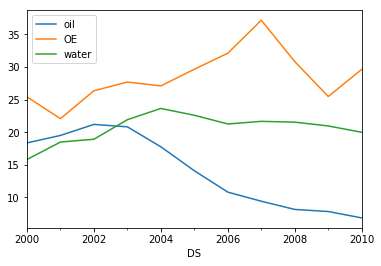

In [16]:
df.loc[df.field=='TROLL'].loc['2000':'2010'].resample('Y').sum().plot()

Or we can get totals for *ALL* fields in the database:

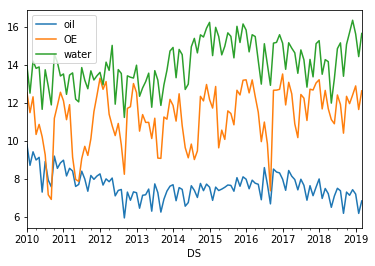

In [17]:
df.loc['2010':].resample('M').sum().plot()

Let's look at the contribution TROLL made to NCS production since 1993:

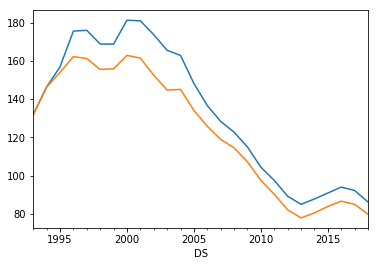

In [18]:
fig, ax = plt.subplots()
df.loc['1993':'2018', 'oil'].resample('Y').sum().plot(ax=ax)
df.loc[df.field!='TROLL'].loc['1993':'2018', 'oil'].resample('Y').sum().plot(ax=ax)

## Forecasting with Facebook prophet

In [0]:
from fbprophet import Prophet

In [20]:
df.head()

,field,oil,OE,water
DS,,,,
2009-07-01,33/9-6 DELTA,0.00025,-0.00004,0.00051
2009-08-01,33/9-6 DELTA,0.00325,0.00014,0.00063
2009-09-01,33/9-6 DELTA,0.00317,0.00010,0.00316
2009-10-01,33/9-6 DELTA,0.00294,0.00012,0.00535
2009-11-01,33/9-6 DELTA,-0.00001,-0.00004,0.00000


The Prophet API requires a column called `'ds'` for the dates, and another called `'y'` for the thing we want to predict. Let's try to predict water.

We'll make a new dataframe just for Troll:

In [0]:
dt = df[df.field=='TROLL'].copy()
dt['ds'] = dt.index
dt['y'] = dt['water']

In [22]:
model = Prophet()

model.fit(dt)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = model.make_future_dataframe(periods=240, freq='M')

In [0]:
forecast = model.predict(future)

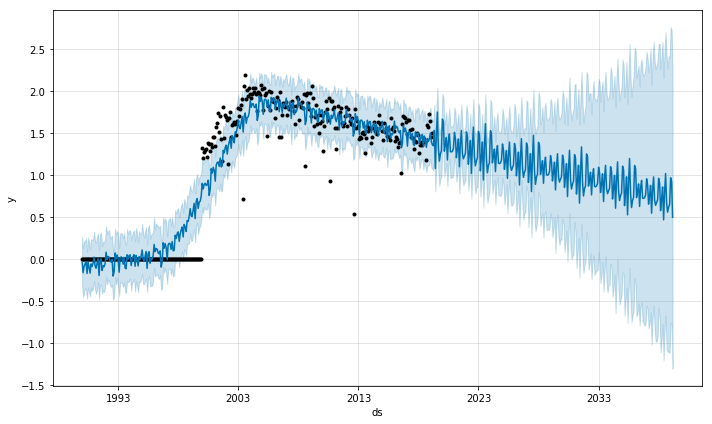

In [25]:
_ = model.plot(forecast)

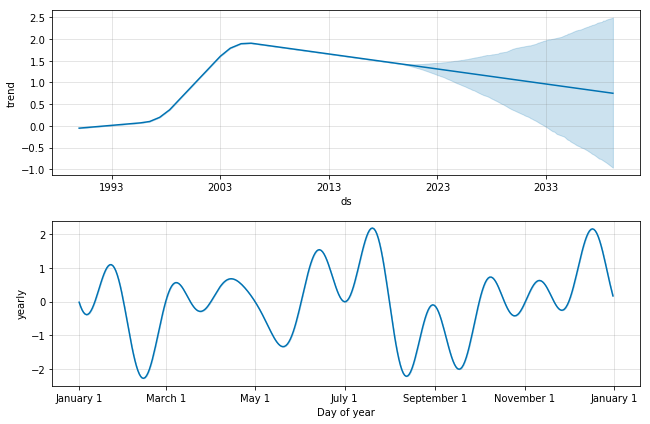

In [26]:
fig = model.plot_components(forecast)

## Logistic growth (with constraints)

In [27]:
dt.head()

,field,oil,OE,water,ds,y
DS,,,,,,
1990-01-01,TROLL,0.07188,0.0,0.0,1990-01-01,0.0
1990-02-01,TROLL,0.07995,0.0,0.0,1990-02-01,0.0
1990-03-01,TROLL,0.12061,0.0,0.0,1990-03-01,0.0
1990-04-01,TROLL,0.12254,0.0,0.0,1990-04-01,0.0
1990-05-01,TROLL,0.08272,0.0,0.0,1990-05-01,0.0


In [28]:
dt['cap'] = 4
dt['floor'] = 0

model = Prophet(growth='logistic')

model.fit(dt)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


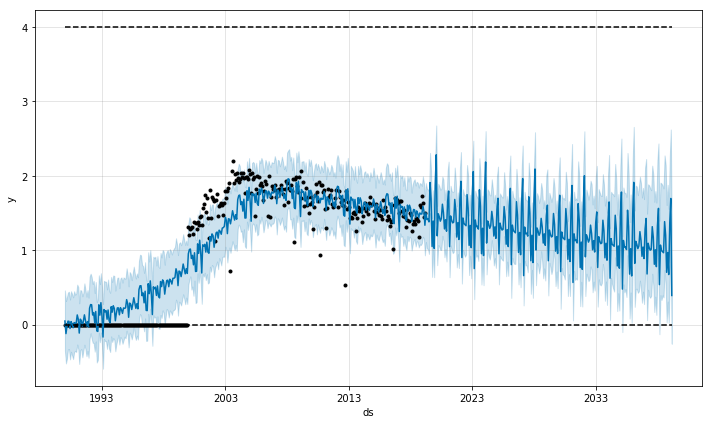

In [29]:
future = model.make_future_dataframe(periods=240, freq='M')
future['cap'] = 4
future['floor'] = 0

forecast = model.predict(future)
fig = model.plot(forecast)

## Controlling the seasonality

The variance is a bit too high; there are ways to control this.

This cell is a little slower to run than the others...

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


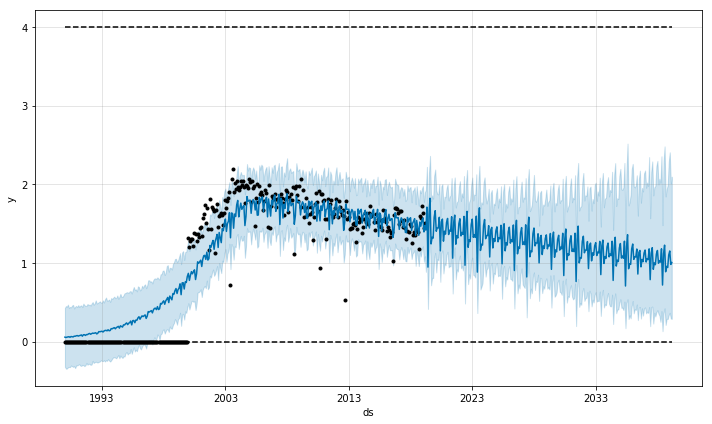

In [30]:
model = Prophet(growth='logistic', seasonality_mode='multiplicative', mcmc_samples=200)

model.fit(dt)

future = model.make_future_dataframe(periods=240, freq='M')
future['cap'] = 4
future['floor'] = 0

forecast = model.predict(future)

fig = model.plot(forecast)